In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
sqlQueryMeasurement = "Select * from measurement;"

with engine.connect() as conn:
    measurementDf = pd.read_sql(sqlQueryMeasurement,con = conn)

measurementDf.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [10]:
queryStation = "Select * from station;"

with engine.connect() as conn:
    stationDf = pd.read_sql(queryStation,con = conn)

stationDf.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(max_date)

('2017-08-23',)


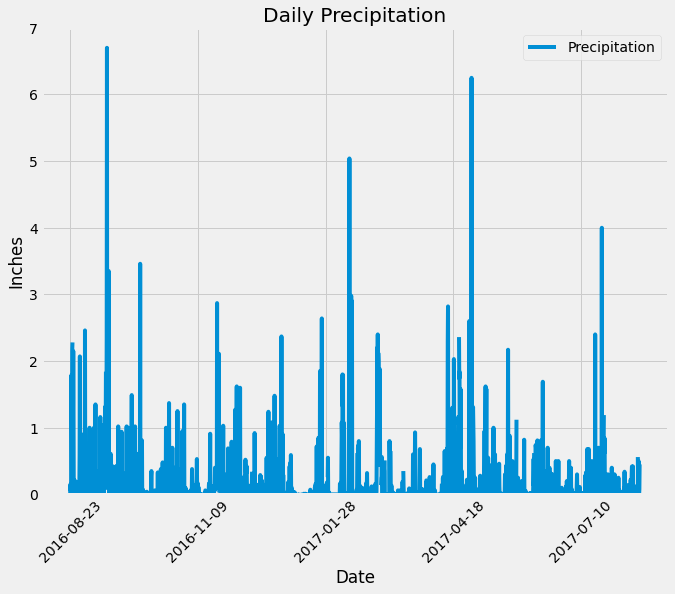

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
lastYear = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipData = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=lastYear).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitationDF = pd.DataFrame(precipData)
precipitationDF.set_index('date').head()

# Sort the dataframe by date
precipitationDF.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitationDFPlot = precipitationDF.plot('date', 'prcp', figsize= (10, 8), ylim=(0,7), title = "Daily Precipitation", rot=45)
precipitationDFPlot.set_ylabel("Inches")
precipitationDFPlot.set_xlabel("Date")
#precipitationDFPlot.grid()
plt.legend(["Precipitation"])
plt.savefig("PrecipitationAnalysis.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitationDF.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
stationsCount = session.query(Station.station).count()
stationsCount

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activeStations = session.query(Measurement.station, func.count(Measurement.station)).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.station).desc()).all()
activeStations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stats = [Measurement.station,
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),]

all_stats = session.query(*stats).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
all_stats

('USC00519281', 54.0, 85.0, 71.66378066378067)

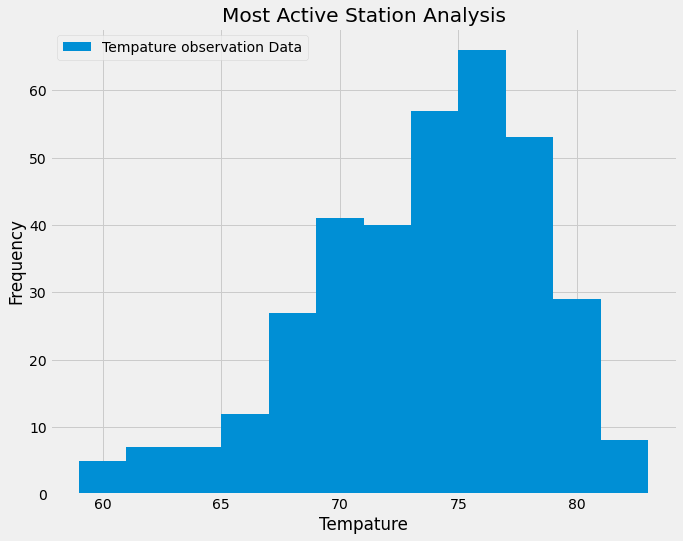

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
popStation = all_stats[0]

tobsData = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station==popStation).\
    filter(Measurement.date>=lastYear).\
        order_by(Measurement.date).all()


tobsDF = pd.DataFrame(tobsData,columns=["date","tobs"])
plt.figure(figsize=(10,8))
plt.hist(tobsDF['tobs'], bins =12)
plt.title("Most Active Station Analysis")
plt.xlabel("Tempature")
plt.ylabel("Frequency")
plt.legend(["Tempature observation Data"])
plt.savefig("tobsHist.png")
plt.show()


# Close session

In [18]:
# Close Session
session.close()